In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZV39AB/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZV39AB/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZV39AB/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_examples, val_examples = examples['train'], examples['validation']

In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [0]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
  return lang1, lang2

In [0]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])
  return result_pt, result_en

In [0]:
# Fillter
MAX_LENGTH = 40

In [0]:
def filter_max_length(x, y, max_length = MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [0]:
# Preprocess

train_preprocess = (train_examples.map(tf_encode).filter(filter_max_length).cache().shuffle(BUFFER_SIZE))

val_preprocess = (val_examples.map(tf_encode).filter(filter_max_length))


In [0]:
# Padding & Batch

train_dataset = train_preprocess.padded_batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_preprocess.padded_batch(BATCH_SIZE)

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [0]:
# Positional Encoding

def get_angle(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2*(i//2) / np.float32(d_model)))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angle(np.arange(position)[:, np.newaxis],  # shape = 50, 1    value: 1,1 ~ 50,1
                         np.arange(d_model)[np.newaxis, :],   # shape = 1, 128   value: 1,1 ~ 1,128
                         d_model)                             # shape = 1,       value: 128
  
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, tf.float32)

(1, 50, 512)


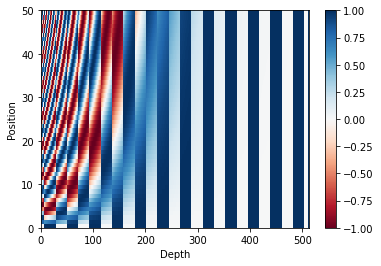

In [16]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
## Masking

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # convert the mask as (b, 1, 1, seq_len)  <- batch, heads, units, seq_len

In [18]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [0]:
## Look ahead Mask <- where is the stop

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [20]:
x = tf.random.uniform((8, 10))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  output = tf.matmul(attention_weights, v)
  return output, attention_weights

In [22]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)


np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [23]:
temp_q = tf.random.normal(shape = (1, 5, 10, 6))
temp_k = tf.random.normal(shape = (1, 5, 10, 6))
temp_v = tf.random.normal(shape = (1, 5, 10, 6))

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[[[0.08123619 0.04710156 0.1141236  0.12401906 0.04037032 0.189476
    0.03475561 0.07918559 0.1875283  0.10220376]
   [0.04094449 0.08350599 0.147843   0.03000765 0.01937057 0.11672851
    0.01950732 0.19635561 0.1967461  0.1489908 ]
   [0.0396053  0.06637065 0.15137072 0.03441772 0.02790586 0.06419218
    0.0202402  0.21054898 0.2249866  0.16036177]
   [0.27868453 0.09013438 0.04976747 0.11604723 0.18057479 0.03454306
    0.15546763 0.0477684  0.01220548 0.03480697]
   [0.10431197 0.07564483 0.07185405 0.18219845 0.03730244 0.3250254
    0.05282784 0.03167719 0.03149727 0.08766055]
   [0.12196749 0.06642666 0.06812891 0.12020417 0.09081215 0.18036667
    0.11945531 0.05116295 0.13050854 0.0509672 ]
   [0.24395633 0.03326032 0.12313271 0.19681564 0.01193398 0.17449597
    0.00812895 0.02243722 0.02384069 0.1619983 ]
   [0.0392025  0.06972831 0.10543932 0.01977631 0.04354092 0.04709474
    0.03955796 0.23346044 0.32664475 0.07555472]
   [0.03242643 0.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % num_heads == 0

    self.depth = d_model // self.num_heads   # ex) d_model == 512, num_heads == 8  
                                             # depth == 64

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # b, seq_len, d_model
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)  # b, num_heads, seq_length, depth
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)  # b, h, len, depth

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # b, len, heads, depth

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # <- concatenate    (b, len, d_model)

    output = self.dense(concat_attention)
    return output, attention_weights

In [25]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), 
                              tf.keras.layers.Dense(d_model)]) # (b, seq_len, d_model)

In [27]:
sample_ffn = point_wise_feed_forward_network(512, 2048)

sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x,x,x, mask)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

In [29]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate= 0.1):
    super(DecoderLayer, self).__init__()
    
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(x + attn1)

    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(out1 + attn2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [31]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [33]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [35]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [37]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

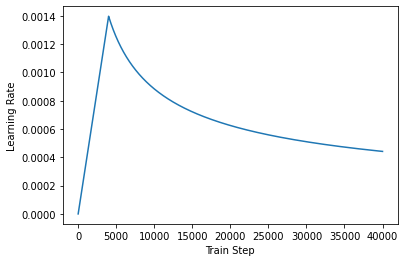

In [41]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [0]:
transformer = Transformer(num_layers, 
                          d_model, 
                          num_heads, 
                          dff,
                          input_vocab_size, 
                          target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
def create_masks_test(inp, tar):
  # Encoder padding mask
  print('Enc Padding Mask')
  enc_padding_mask = create_padding_mask(inp)
  print(enc_padding_mask)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  print('Dec Padding Mask')
  dec_padding_mask = create_padding_mask(inp)
  print(dec_padding_mask)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  print('Dec Look Ahead Mask')
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  print(look_ahead_mask)

  print('Dec target padding Mask')
  dec_target_padding_mask = create_padding_mask(tar)
  print(dec_target_padding_mask)
  
  print('Dec Combined Mask')
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  print(combined_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [60]:
for pt_temp, en_temp in train_dataset.take(1):
  print('Pt Data Set')
  print(pt_temp)
  print()
  print('En Data Set')
  print(en_temp)
  print()
  en_mask_temp, comb_mask_temp, dc_mask_temp = create_masks_test(pt_temp, en_temp)
  


Pt Data Set
tf.Tensor(
[[8214    6   84 ...    0    0    0]
 [8214  149    9 ...    0    0    0]
 [8214    6 1646 ...    0    0    0]
 ...
 [8214   13  137 ...    0    0    0]
 [8214   18 6264 ...    0    0    0]
 [8214   59  154 ...    0    0    0]], shape=(64, 36), dtype=int64)

En Data Set
tf.Tensor(
[[8087    4  145 ...    0    0    0]
 [8087 2081  982 ...    0    0    0]
 [8087   14  238 ...    0    0    0]
 ...
 [8087  204  215 ...    0    0    0]
 [8087    4 3598 ...    0    0    0]
 [8087   16  166 ...    0    0    0]], shape=(64, 37), dtype=int64)

Enc Padding Mask
tf.Tensor(
[[[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 ...


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]], shape=(64, 1, 1, 36), dtype=float32)
Dec Padding Mask
tf.Tensor(
[[[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1. 1. 1.]]]


 ...


 [[[0. 0. 0. ... 1. 1. 1.]]]


 [[[0. 0. 0. ... 1.

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
EPOCHS = 20

In [0]:
train_step_signature = [tf.TensorSpec(shape=(None, None), dtype=tf.int64),
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64),]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, 
                                 tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [0]:
import time

In [51]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0001 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9490 Accuracy 0.0020
Epoch 1 Batch 100 Loss 8.8641 Accuracy 0.0140
Epoch 1 Batch 150 Loss 8.7663 Accuracy 0.0184
Epoch 1 Batch 200 Loss 8.6427 Accuracy 0.0207
Epoch 1 Batch 250 Loss 8.4908 Accuracy 0.0225
Epoch 1 Batch 300 Loss 8.3160 Accuracy 0.0246
Epoch 1 Batch 350 Loss 8.1301 Accuracy 0.0285
Epoch 1 Batch 400 Loss 7.9466 Accuracy 0.0327
Epoch 1 Batch 450 Loss 7.7812 Accuracy 0.0361
Epoch 1 Batch 500 Loss 7.6334 Accuracy 0.0388
Epoch 1 Batch 550 Loss 7.5009 Accuracy 0.0416
Epoch 1 Batch 600 Loss 7.3773 Accuracy 0.0447
Epoch 1 Batch 650 Loss 7.2628 Accuracy 0.0478
Epoch 1 Batch 700 Loss 7.1534 Accuracy 0.0509
Epoch 1 Loss 7.1488 Accuracy 0.0510
Time taken for 1 epoch: 84.60090732574463 secs

Epoch 2 Batch 0 Loss 5.4169 Accuracy 0.0998
Epoch 2 Batch 50 Loss 5.5192 Accuracy 0.0998
Epoch 2 Batch 100 Loss 5.4717 Accuracy 0.1033
Epoch 2 Batch 150 Loss 5.4157 Accuracy 0.1063
Epoch 2 Batch 200 Loss 5.3607 Accuracy 0.1084
Ep

In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]

  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token

  encoder_input = tf.expand_dims(inp_sentence, 0)

  decoder_input = [tokenizer_en.vocab_size] # <- start token
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    create_masks_test(encoder_input, output)
    
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    print(predictions.shape)

    predictions = predictions[:, -1:, :] # select last word

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    output = tf.concat([output, predicted_id], axis=-1)
  
  return tf.squeeze(output, axis=0), attention_weights      

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize':10}

    ax.set_xticks(range(len(sentence) + 2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'], fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result if i < tokenizer_en.vocab_size], fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])

  print('Input : {}'.format(sentence))
  print('Predicted: {}'.format(predicted_sentence))

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [68]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
Dec Combined Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
(1, 1, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0. 0.]]]], shape=(1, 1, 1, 2), dtype=float32)
Dec Combined Mask
tf.Tensor(
[[[[0. 1.]
   [0. 0.]]]], shape=(1, 1, 2, 2), dtype=float32)
(1, 2, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1

In [69]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
Dec Combined Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
(1, 1, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0. 0.]]]], shape=(1, 1, 1, 2), dtype=float32)
Dec Combined Mask
tf.Tensor(
[[[[0. 1.]
   [0. 0.]]]], shape=(1, 1, 2, 2), dtype=float32)
(1, 2, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1

In [70]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 20), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 20), dtype=float32)
Dec Look Ahead Mask
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
Dec Combined Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
(1, 1, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 20), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 20), dtype=float32)
Dec Look Ahead Mask
tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0. 0.]]]], shape=(1, 1, 1, 2), dtype=float32)
Dec Combined Mask
tf.Tensor(
[[[[0. 1.]
   [0. 0.]]]], shape=(1, 1, 2, 2

Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
Dec Combined Mask
tf.Tensor([[[[0.]]]], shape=(1, 1, 1, 1), dtype=float32)
(1, 1, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1, 1, 1, 11), dtype=float32)
Dec Look Ahead Mask
tf.Tensor(
[[0. 1.]
 [0. 0.]], shape=(2, 2), dtype=float32)
Dec target padding Mask
tf.Tensor([[[[0. 0.]]]], shape=(1, 1, 1, 2), dtype=float32)
Dec Combined Mask
tf.Tensor(
[[[[0. 1.]
   [0. 0.]]]], shape=(1, 1, 2, 2), dtype=float32)
(1, 2, 8089)
Enc Padding Mask
tf.Tensor([[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(1

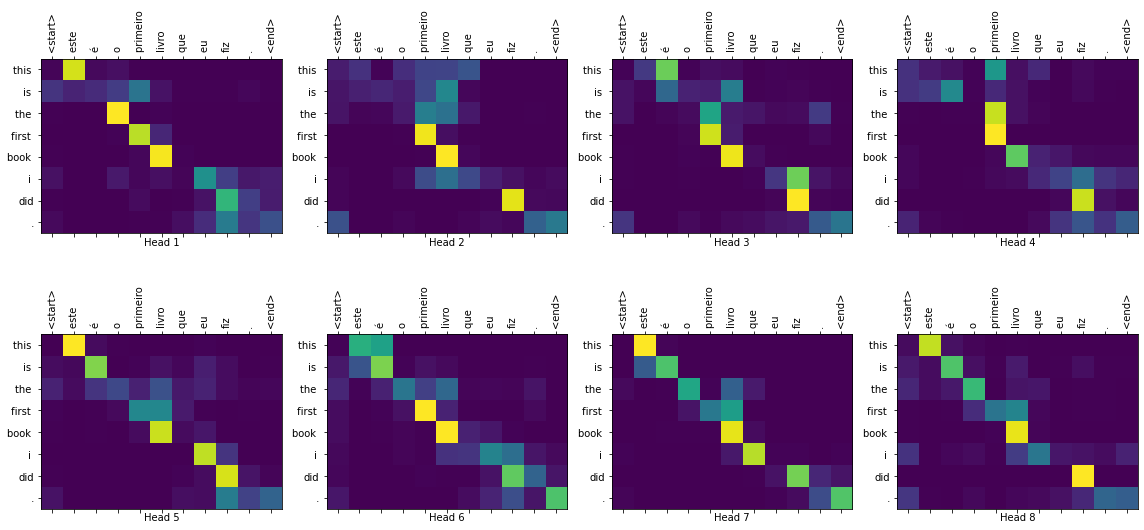

Real translation: this is the first book i've ever done.


In [75]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")